In [286]:
import os
import pandas as pd
from ggplot import *
import numpy as np
import matplotlib.pyplot as plt

import seasonal
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

#%matplotlib inline

# Data Location within CC DS
data_location = os.path.join("..","data","external")


#######################################################
# Helpful Functions I may need

def CAGR(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    first = df.head(1)
    last = df.tail(1)
    periods = (last.Date-first.Date).astype('timedelta64[m]')
    
    return periods



#######################################################
# Create Lists of Columns for Subsetting Data for Analysis
# Create Mapping of Column Names for Cleanliness
#


compset_oar_list = ['Date',
                   'Region',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

compset_oar_mapping = {
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR_TRANS',
                   'ADR-Grp.':'ADR_GRP',
                   'ADR-Cont.':'ADR_CONT',
                   'ADR-Total':'ADR_TOTAL',
                   'RevPAR-Trans.':'RevPAR_TRANS',
                   'RevPAR-Grp.':'RevPAR_GRP',
                   'RevPAR-Cont.':'RevPAR_CONT',
                    'RevPAR-Total':'RevPAR_TOTAL'
                    }


m_cnty_oar_list = ['Year',
                   'Month',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

m_cnty_oar_mapping = {
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR_TRANS',
                   'ADR-Grp.':'ADR_GRP',
                   'ADR-Cont.':'ADR_CONT',
                   'ADR-Total':'ADR_TOTAL',
                   'RevPAR-Trans.':'RevPAR_TRANS',
                   'RevPAR-Grp.':'RevPAR_GRP',
                   'RevPAR-Cont.':'RevPAR_CONT',
                    'RevPAR-Total':'RevPAR_TOTAL'
                }



region_mapping = {'Long Beach/Torrance':'LBT',
                   'Sonoma County, CA':'SON C',
                   'Napa County, CA':'NAPA C',
                   'Santa Barbara County, CA': 'SB',
                   'Monterey County, CA':'MONT',
                   'City of Monterey, CA':"CMONT",
                   'San Diego, CA':'SD',
                   'Santa Barbara/Santa Maria, CA':'SBSM',
                   'San Francisco/San Mateo, CA':'SF',
                   'South Lake Tahoe, CA':'SLT',
                   'Laguna Beach, CA':'LAG',
                   'San Jose-Santa Cruz, CA':'SJ',
                   'Palm Springs, CA':'PS',
                   'Napa Valley, CA':'NV',
                   'Newport Beach/Dana Point, CA':'NPB'}


region_exclude = ['Long Beach/Torrance']


# Read in Monterey County XLS
#
# Documentation for Monterey County XLS goes here...
file_path = os.path.join(data_location, "Monterey-County-City-STR-ALL.xlsx")
m_cnty = pd.read_excel(file_path, sheetname = "County of Monterey 05-16 Seg")
m_city = pd.read_excel(file_path, sheetname = "City of Monterey 13-16 Seg")

# Read in Compset data
file_path = os.path.join(data_location, "Comp-Set-STR-ALL.xlsx")
compset_hm = pd.read_excel(file_path, sheetname = "Comp-Set OCC-ADR-RevPARv2")

# Read in Budget data
file_path = os.path.join(data_location, "TID_BUDGET.xlsx")
budget = pd.read_excel(file_path, sheetname = "income")


In [287]:
###################################################
# Process city of monterey
m_city_v1 = m_city[m_cnty_oar_list]
m_city_v2 = m_city_v1.rename(columns=m_cnty_oar_mapping)

m_city_v2['Month'] = m_city_v2['Month'].apply(str)
m_city_v2['Year'] = m_city_v2['Year'].apply(str)
m_city_v2['Date'] = m_city_v2['Year'] + "-" + m_cnty['Month']
m_city_v2['Date'] = pd.to_datetime(m_cnty_v2['Date'], format = "%Y-%b")
m_city_v2['Month'] = m_city_v2['Date'].apply(lambda x: x.month)

m_city_v2['Region'] = 'City of Monterey, CA'


###################################################
# Process monterey_county
m_cnty_v1 = m_cnty[m_cnty_oar_list]
m_cnty_v2 = m_cnty_v1.rename(columns=m_cnty_oar_mapping)


m_cnty_v2['Month'] = m_cnty_v2['Month'].apply(str)
m_cnty_v2['Year'] = m_cnty_v2['Year'].apply(str)
m_cnty_v2['Date'] = m_cnty_v2['Year'] + "-" + m_cnty['Month']
m_cnty_v2['Date'] = pd.to_datetime(m_cnty_v2['Date'], format = "%Y-%b")
m_cnty_v2['Month'] = m_cnty_v2['Date'].apply(lambda x: x.month)

m_cnty_v2['Region'] = 'Monterey County, CA'

###################################################
# Process compset data
compset_hm_v1 = compset_hm = compset_hm[compset_oar_list]
compset_hm_v2 = compset_hm_v1.rename(columns=compset_oar_mapping)

#Date & Time Manipulation
compset_hm_v2['Date'] = pd.to_datetime(compset_hm_v2['Date'])
compset_hm_v2['Month'] = compset_hm_v2['Date'].apply(lambda x: str(x.month))
compset_hm_v2['Year'] = compset_hm_v2['Date'].apply(lambda x: str(x.year))


#String Manipulation
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('+','')
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('San Jose/Santa Cruz, CA','San Jose-Santa Cruz, CA')
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('Santa Barbara/Santa Maria, CA','Santa Barbara County, CA')
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('Napa Valley, CA','Napa County, CA')



In [288]:
###############################################
# Combine datasets for Hotel Metrics 
tot_set = compset_hm_v2.append(m_cnty_v2)
tot_set = tot_set.append(m_city_v2)

# Sort before Calculations (Do I need to do this?)
tot_set = tot_set[tot_set['Date'] > '2011-04-01']
tot_set = tot_set.sort_values(by=['Date'], ascending = True)
tot_set = tot_set.round(2)
tot_set = tot_set.reset_index()


#String Manipulation
#tot_set = tot_set.replace({'Region':region_mapping})
tot_set['Month'] = tot_set['Month'].apply(str)

# Drop Duplicates
tot_set = tot_set.drop_duplicates(subset=['Region','Year','Month'])



#Region Exclusion
tot_set = tot_set[~(tot_set['Region'].isin(region_exclude))]

##############################################
# Calculate metrics, in this case, simple growth MOM & YOY
# May consider YTD

#Average Daily Rate  MOM & YOY
tot_set['ADR_GRP_MOM'] =     tot_set.groupby(['Region'])['ADR_GRP'].pct_change(1)
tot_set['ADR_TRANS_MOM'] =   tot_set.groupby(['Region'])['ADR_TRANS'].pct_change(1)
tot_set['ADR_TOTAL_MOM'] =   tot_set.groupby(['Region'])['ADR_TOTAL'].pct_change(1)

tot_set['ADR_GRP_YOY'] =     tot_set.groupby(['Region'])['ADR_GRP'].pct_change(12)
tot_set['ADR_TRANS_YOY'] =   tot_set.groupby(['Region'])['ADR_TRANS'].pct_change(12)
tot_set['ADR_TOTAL_YOY'] =   tot_set.groupby(['Region'])['ADR_TOTAL'].pct_change(12)

tot_set[(tot_set['Region'] == 'City of Monterey, CA') & (tot_set['Month'] == "7")][['OCC_GRP','OCC_TOTAL','OCC_TRANS']]

,OCC_GRP,OCC_TOTAL,OCC_TRANS
12,NaN,NaN,NaN
100,25.26,86.22,59.62
180,14.66,87.62,64.15
277,22.18,88.50,59.33
443,16.05,90.19,73.45
597,19.11,92.41,73.06


In [289]:


#Occupancy MOM & YOY
tot_set['OCC_GRP_MOM'] =     tot_set.groupby(['Region'])['OCC_GRP'].pct_change(1)
tot_set['OCC_TRANS_MOM'] =   tot_set.groupby(['Region'])['OCC_TRANS'].pct_change(1)
tot_set['OCC_TOTAL_MOM'] =   tot_set.groupby(['Region'])['OCC_TOTAL'].pct_change(1)
tot_set['OCC_GRP_ANN'] = tot_set.groupby(['Region'])['RevPAR_GRP_MOM'].apply(pd.rolling_mean, 12)

tot_set['OCC_GRP_YOY'] =     tot_set.groupby(['Region'])['OCC_GRP'].pct_change(12)
tot_set['OCC_TRANS_YOY'] =   tot_set.groupby(['Region'])['OCC_TRANS'].pct_change(12)
tot_set['OCC_TOTAL_YOY'] =   tot_set.groupby(['Region'])['OCC_TOTAL'].pct_change(12)


#RevPar MOM & YOY
tot_set['RevPAR_GRP_MOM'] =     tot_set.groupby(['Region'])['RevPAR_GRP'].pct_change(1)
tot_set['RevPAR_TRANS_MOM'] =   tot_set.groupby(['Region'])['RevPAR_TRANS'].pct_change(1)
tot_set['RevPAR_TOTAL_MOM'] =   tot_set.groupby(['Region'])['RevPAR_TOTAL'].pct_change(1)

tot_set['RevPAR_GRP_YOY'] =     tot_set.groupby(['Region'])['RevPAR_GRP'].pct_change(12)
tot_set['RevPAR_TRANS_YOY'] =   tot_set.groupby(['Region'])['RevPAR_TRANS'].pct_change(12)
tot_set['RevPAR_TOTAL_YOY'] =   tot_set.groupby(['Region'])['RevPAR_TOTAL'].pct_change(12)


#RevPAR Rolling Mean
tot_set['RevPAR_GRP_MOM_ROLL_QTR'] = tot_set.groupby(['Region'])['RevPAR_GRP_MOM'].apply(pd.rolling_mean, 3)

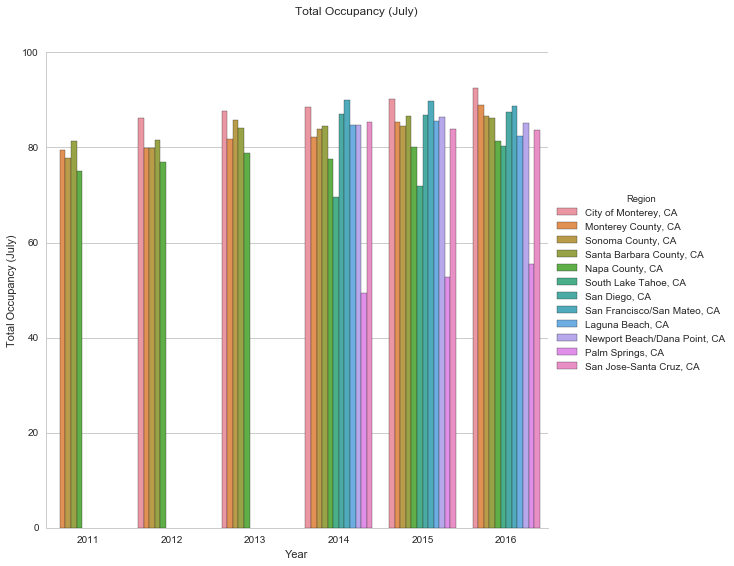

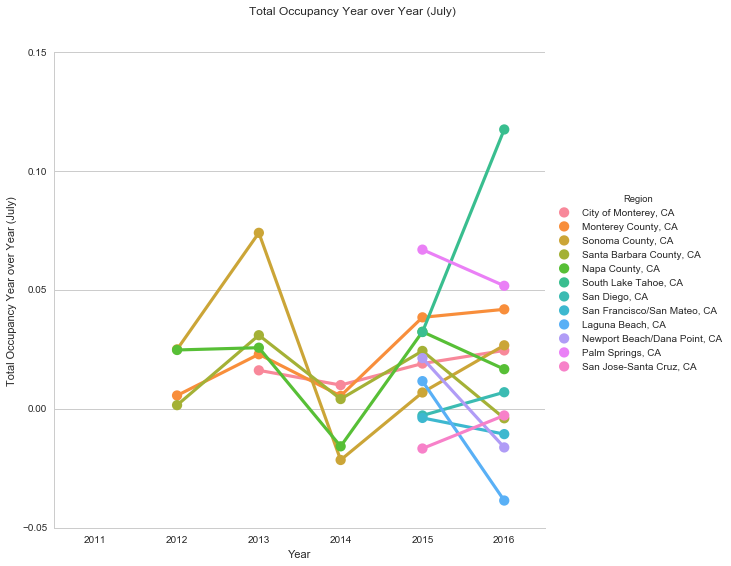

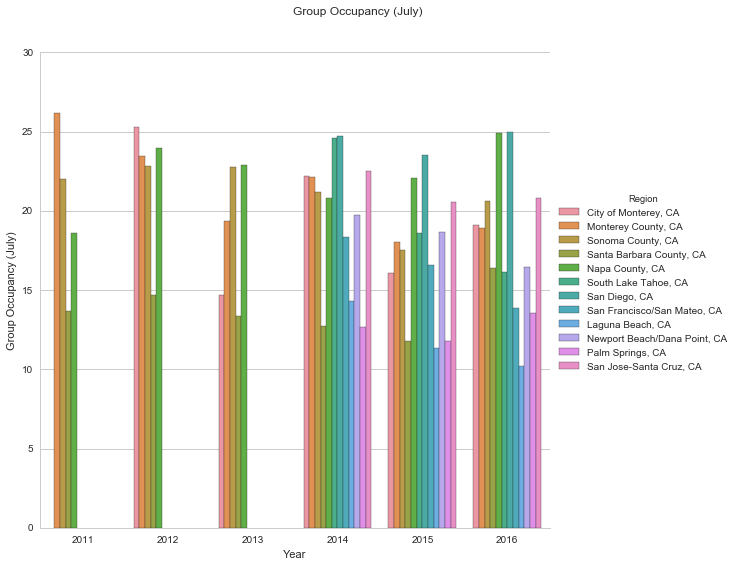

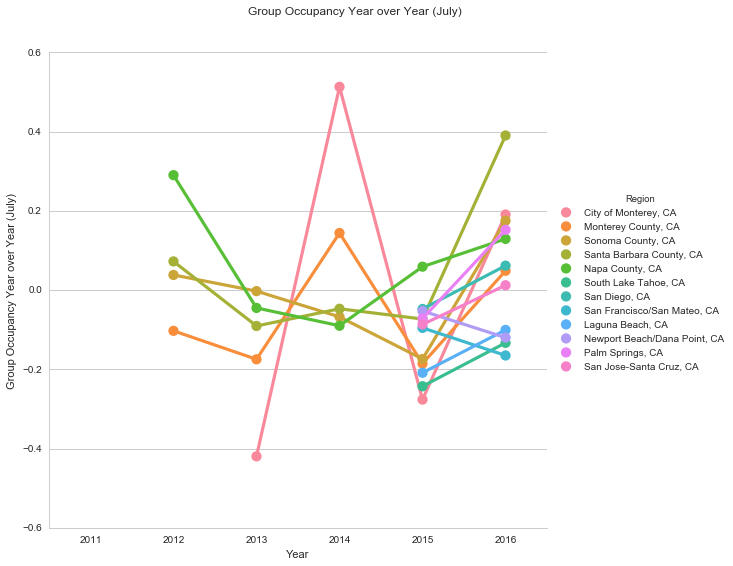

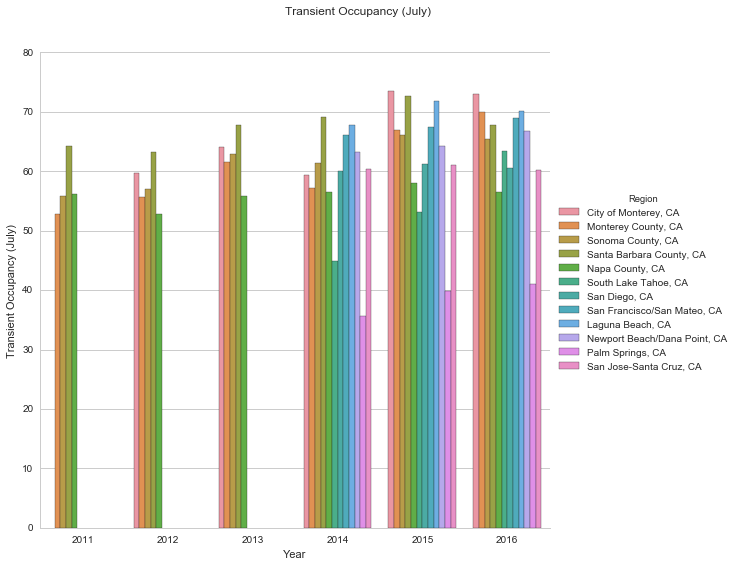

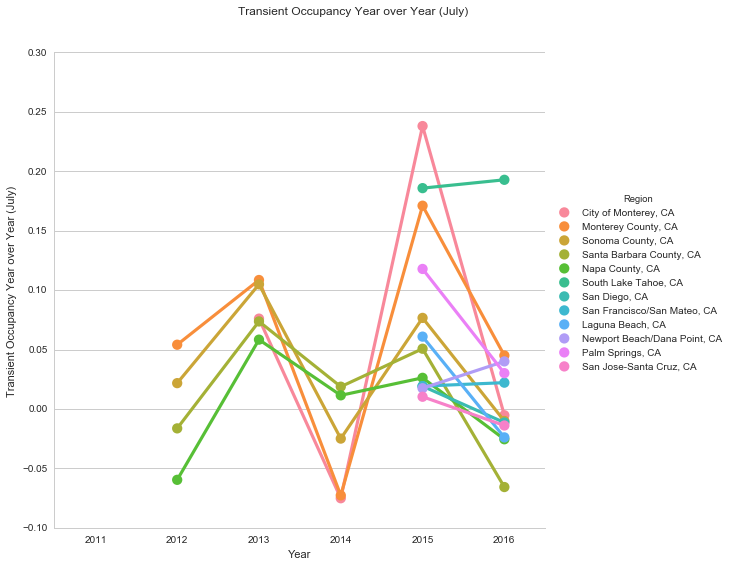

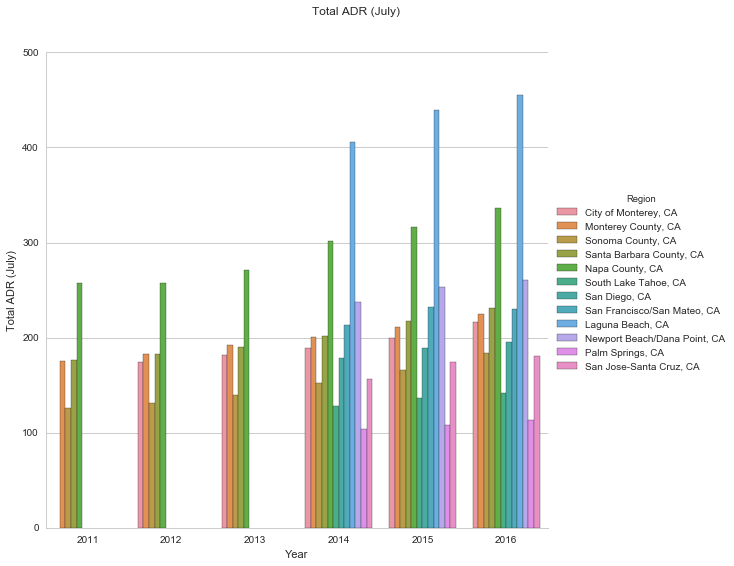

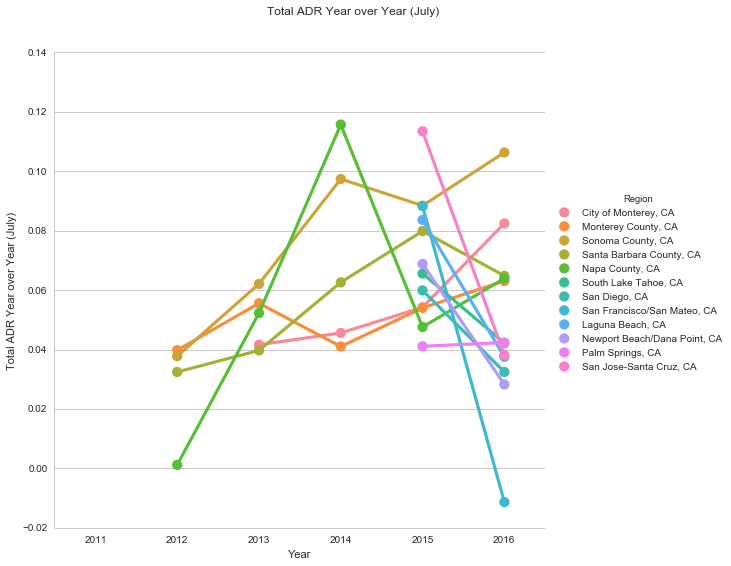

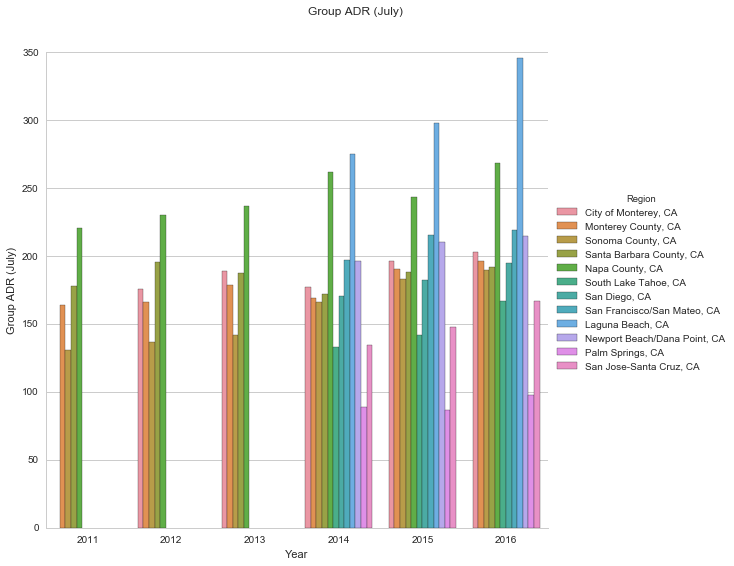

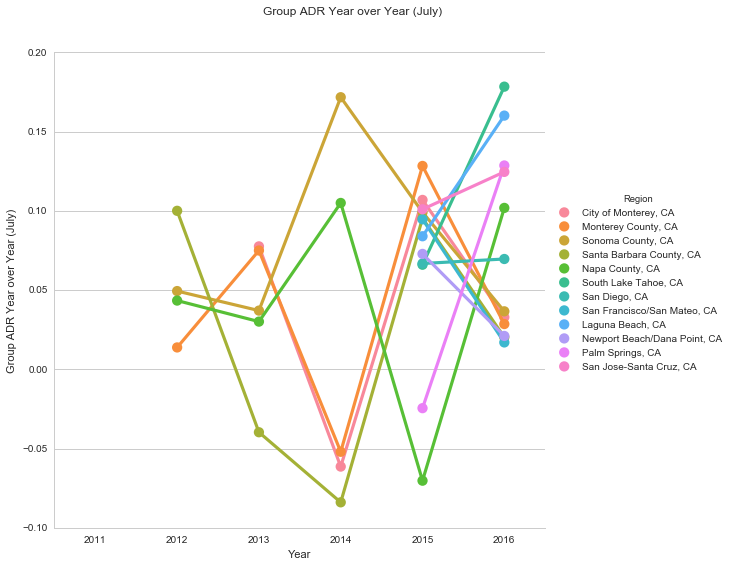

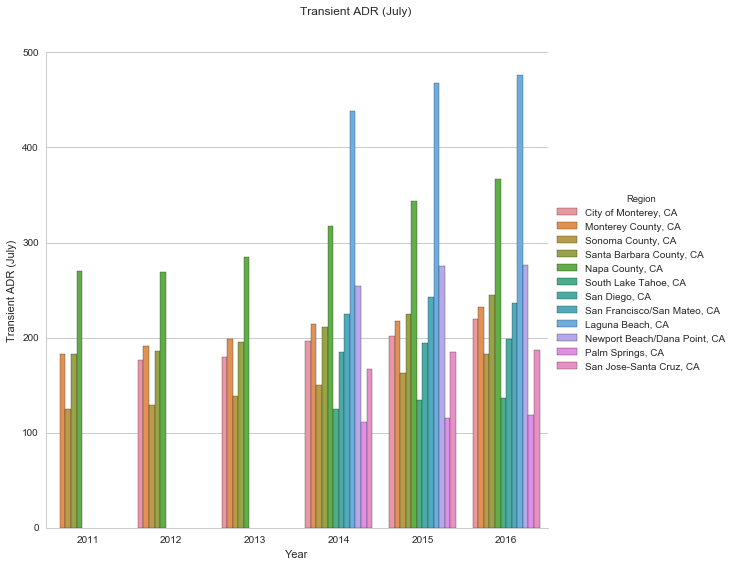

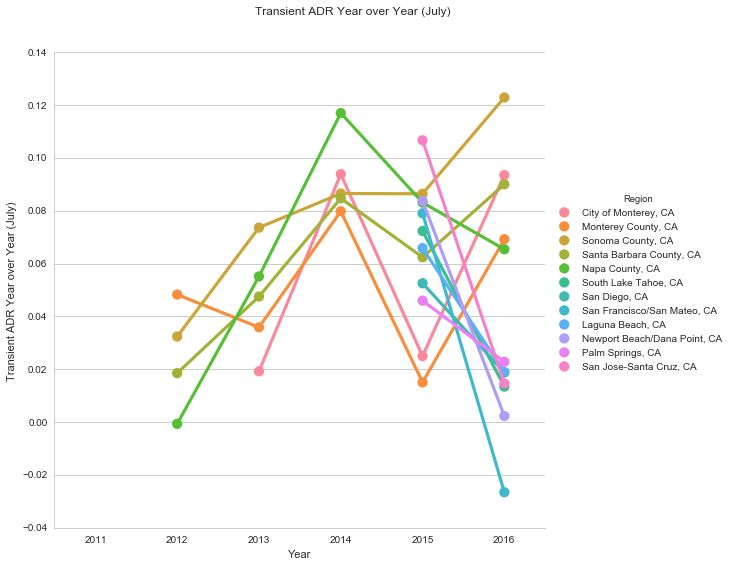

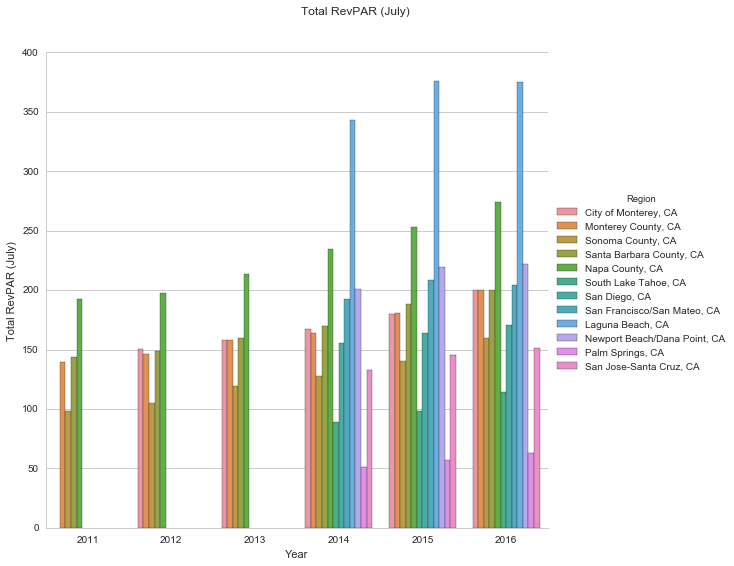

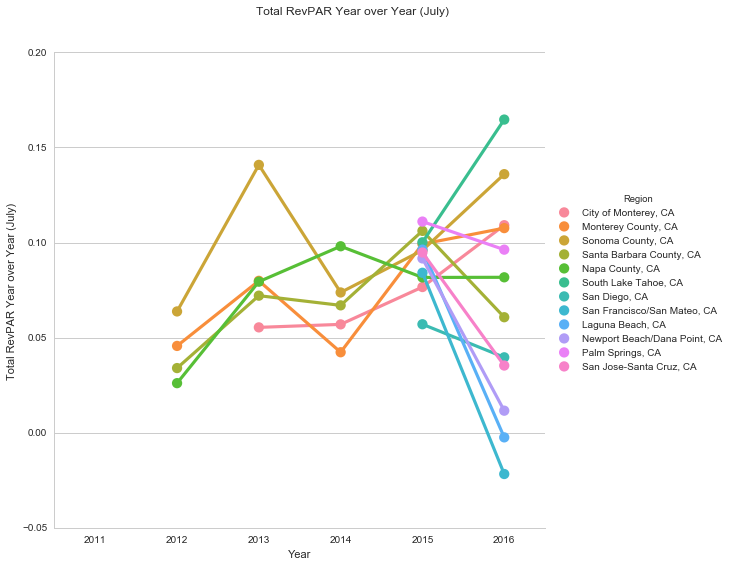

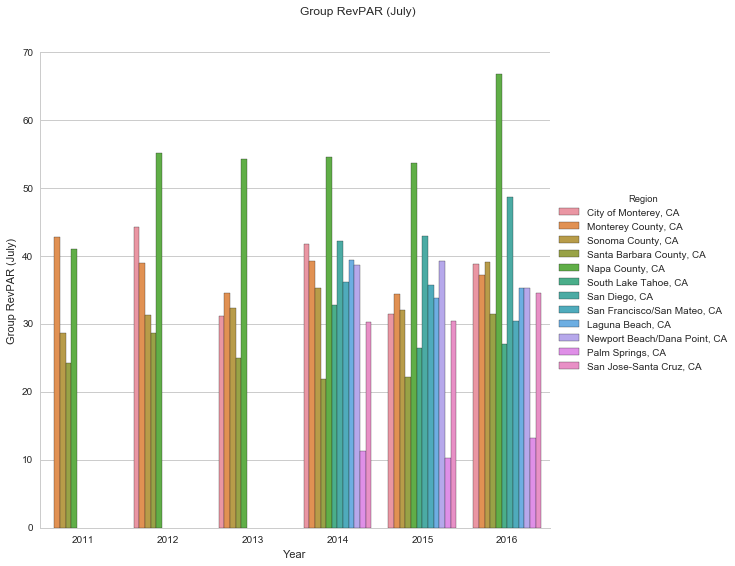

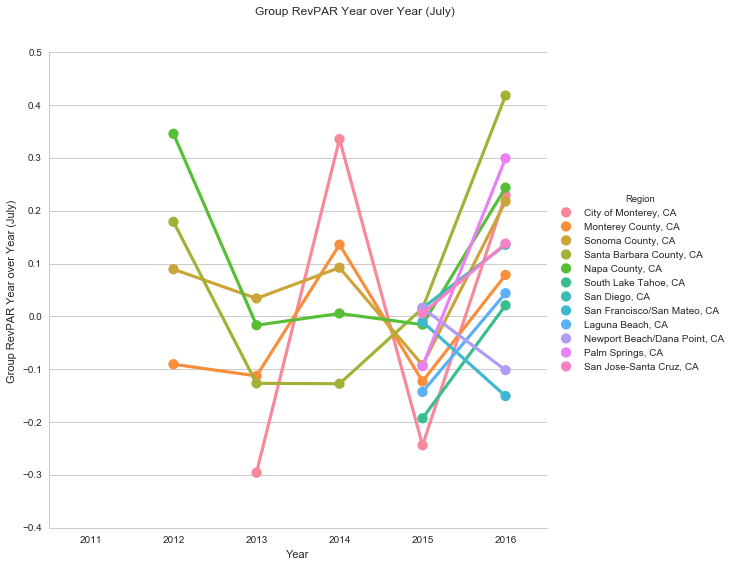

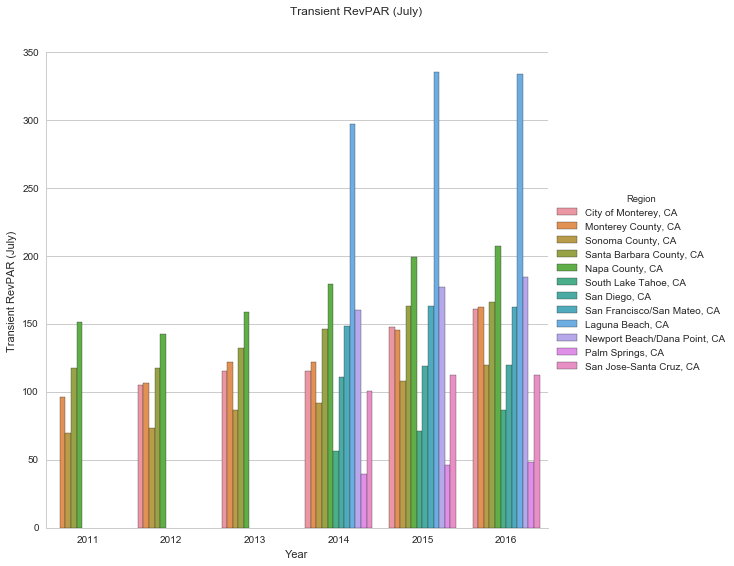

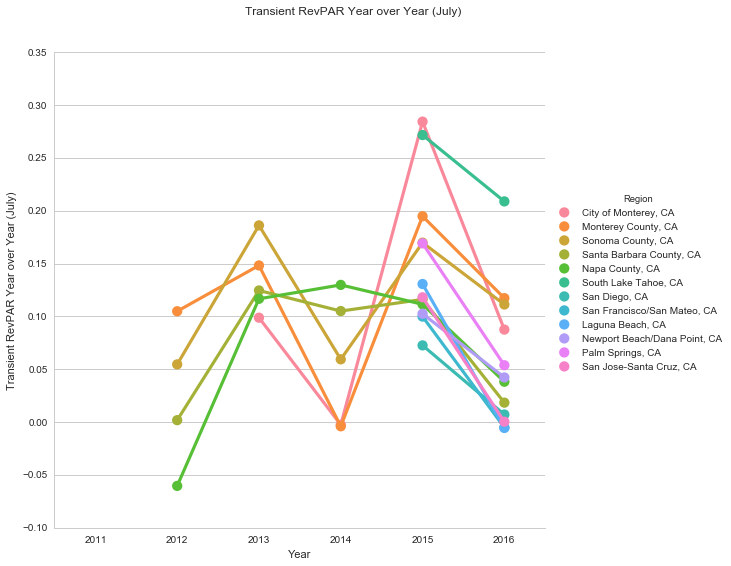

In [300]:
##################################################
# Let's visualize this data for output to Tammy & Rob
# 

#Getting a feel for it
viz_set = tot_set
viz_set['Date'] = pd.to_datetime(viz_set['Date'])
viz_set['Month-Year'] = viz_set['Date'].apply(lambda x: str(x.month) + "-" + str(x.year))
viz_set = viz_set.sort_values(by=['Date'])

# Subset for July, our Peak Month
plot_data = viz_set[viz_set['Month'] == "7"]


###################################
# Occupancy Totals & Group & Trans

#Total
ax = sns.factorplot(x='Year',y='OCC_TOTAL',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Total Occupancy (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total Occupancy (July)')
plt.savefig('Occ_Total_July.pdf')

ax = sns.factorplot(x='Year',y='OCC_TOTAL_YOY',hue='Region',data=plot_data,size=8)
ax = ax.set(ylabel='Total Occupancy Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total Occupancy Year over Year (July)')
plt.savefig('Occ_Total_YOY_July.pdf')

#Group
ax = sns.factorplot(x='Year',y='OCC_GRP',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Group Occupancy (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group Occupancy (July)')
plt.savefig('Occ_Grp_July.pdf')

ax = sns.factorplot(x="Year", y="OCC_GRP_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Group Occupancy Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group Occupancy Year over Year (July)')
plt.savefig('Occ_Grp_YOY_July.pdf')

#Trans
ax = sns.factorplot(x='Year',y='OCC_TRANS',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Transient Occupancy (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient Occupancy (July)')
plt.savefig('Occ_Trans_July.pdf')

ax = sns.factorplot(x="Year", y="OCC_TRANS_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Transient Occupancy Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient Occupancy Year over Year (July)')
plt.savefig('Occ_Trans_YOY_July.pdf')



###################################
# ADR Totals & Group & Trans

#Total
ax = sns.factorplot(x='Year',y='ADR_TOTAL',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Total ADR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total ADR (July)')
plt.savefig('ADR_Total_July.pdf')

ax = sns.factorplot(x='Year',y='ADR_TOTAL_YOY',hue='Region',data=plot_data,size=8)
ax = ax.set(ylabel='Total ADR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total ADR Year over Year (July)')
plt.savefig('ADR_Total_YOY_July.pdf')

#Group
ax = sns.factorplot(x='Year',y='ADR_GRP',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Group ADR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group ADR (July)')
plt.savefig('ADR_Grp_July.pdf')

ax = sns.factorplot(x="Year", y="ADR_GRP_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Group ADR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group ADR Year over Year (July)')
plt.savefig('ADR_Grp_YOY_July.pdf')

#Trans
ax = sns.factorplot(x='Year',y='ADR_TRANS',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Transient ADR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient ADR (July)')
plt.savefig('ADR_Trans_July.pdf')

ax = sns.factorplot(x="Year", y="ADR_TRANS_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Transient ADR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient ADR Year over Year (July)')
plt.savefig('ADR_Trans_YOY_July.pdf')


###################################
# RevPAR Totals & Group & Trans

#Total
ax = sns.factorplot(x='Year',y='RevPAR_TOTAL',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Total RevPAR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total RevPAR (July)')
plt.savefig('RevPAR_Total_July.pdf')

ax = sns.factorplot(x='Year',y='RevPAR_TOTAL_YOY',hue='Region',data=plot_data,size=8)
ax = ax.set(ylabel='Total RevPAR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Total RevPAR Year over Year (July)')
plt.savefig('RevPAR_Total_YOY_July.pdf')

#Group
ax = sns.factorplot(x='Year',y='RevPAR_GRP',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Group RevPAR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group RevPAR (July)')
plt.savefig('RevPAR_Grp_July.pdf')

ax = sns.factorplot(x="Year", y="RevPAR_GRP_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Group RevPAR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Group RevPAR Year over Year (July)')
plt.savefig('RevPAR_Grp_YOY_July.pdf')

#Trans
ax = sns.factorplot(x='Year',y='RevPAR_TRANS',hue='Region',data=plot_data,size=8, kind='bar')
ax = ax.set(ylabel='Transient RevPAR (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient RevPAR (July)')
plt.savefig('RevPAR_Trans_July.pdf')

ax = sns.factorplot(x="Year", y="RevPAR_TRANS_YOY", hue="Region", data=plot_data, size=8)
ax = ax.set(ylabel='Transient RevPAR Year over Year (July)')
plt.subplots_adjust(top=.9)
ax.fig.suptitle('Transient RevPAR Year over Year (July)')
plt.savefig('RevPAR_Trans_YOY_July.pdf')






In [291]:
plot_data[plot_data['Region'] == 'City of Monterey, CA'][['Date','RevPAR_GRP_YOY']]


,Date,RevPAR_GRP_YOY
12,2011-07-01,NaN
100,2012-07-01,NaN
180,2013-07-01,-0.295670
277,2014-07-01,0.335895
443,2015-07-01,-0.243768
597,2016-07-01,0.229794


In [292]:
viz_set.to_csv("total_data_visualization.csv",index=False)

#viz_set[viz_set['Region']=='City of Monterey, CA']